## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

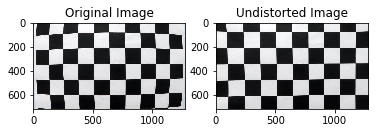

In [38]:
from find_lane import *
%matplotlib qt
%matplotlib inline 

# Calibrate using checkerboard
calib_imgs = glob.glob('./camera_cal/*.jpg')
example_img = cv2.imread(calib_imgs[0])
img_size = (example_img.shape[1], example_img.shape[0])

objpoints, imgpoints = find_obj_img_point_pairs(calib_imgs, 9, 6)
camera_matrix, dist_coeffs = calibrate(objpoints, imgpoints, img_size)

# Show undistort example
example_undistorted = cv2.undistort(example_img, camera_matrix, dist_coeffs, None, camera_matrix)

plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(example_undistorted)
plt.title("Undistorted Image")

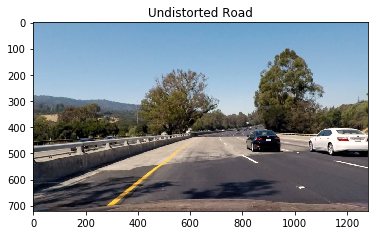

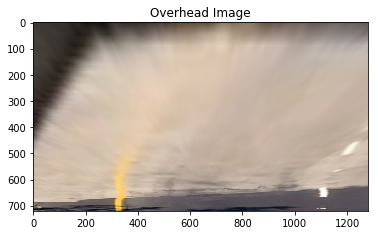

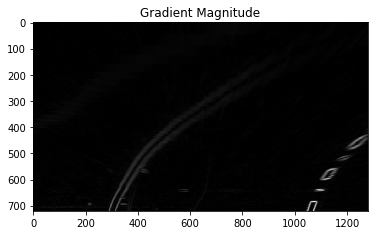

In [45]:
# Get overhead transformation
(dy,dx) = (720, 1280)
SOURCE = np.float32([(278, 670), (616, 437), (662, 437), (1025, 670)])
DESTIN = np.float32([(278, dy), (278, 0), (1025, 0), (1025, dy)])
M_trans = cv2.getPerspectiveTransform(SOURCE, DESTIN)

def pipeline(img):
    # Undistort
    img = cv2.undistort(img, camera_matrix, dist_coeffs, None, camera_matrix)
    
    # Show undistorted road
    plt.imshow(img)
    plt.title("Undistorted Road")
    
    # Show example overhead image
    overhead = cv2.warpPerspective(img, M_trans, (dx, dy))
    plt.figure()
    plt.imshow(overhead)
    plt.title("Overhead Image")
    
    # Change color space
    hls = cv2.cvtColor(overhead, cv2.COLOR_BGR2HLS)
    L = hls[:, :, 1]
    
    # Sobel
    kernel_size = 13
    sobelx = cv2.Sobel(fltr_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(fltr_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    gradmag = (sobelx ** 2 + sobely ** 2) ** 0.5
    
    # Show sobel
    plt.figure()
    plt.title("Gradient Magnitude")
    plt.imshow(gradmag, cmap='gray')

    
test_imgs = glob.glob('./test_images/*.jpg')
img = plt.imread(test_imgs[])
pipeline(img)

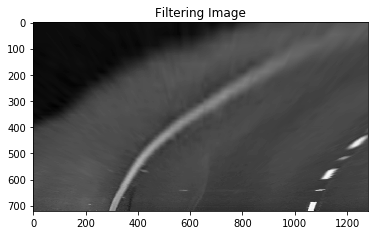

In [46]:
hls = cv2.cvtColor(overhead, cv2.COLOR_BGR2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]
# plt.figure()
# plt.imshow(H, cmap='gray')
# plt.title("H")
# plt.figure()
# plt.imshow(L, cmap='gray')
# plt.title("L")
# plt.figure()
# plt.imshow(S, cmap='gray')
# plt.title("S")

# Filter image
fltr_img = L
plt.figure()
plt.imshow(fltr_img, cmap='gray')
plt.title("Filtering Image")

In [47]:
# Blur
blur_kernel = (5, 5)
img = cv2.GaussianBlur(fltr_img, blur_kernel, 0)

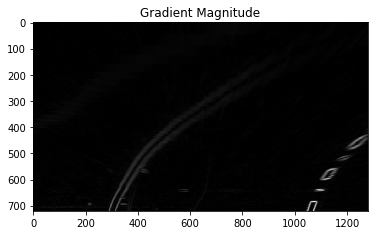

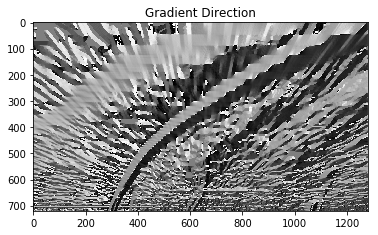

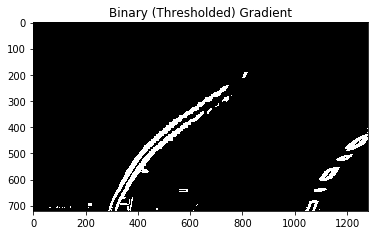

In [48]:
# Sobel
mag_min = 0.4
kernel_size = 13

sobelx = cv2.Sobel(fltr_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
sobely = cv2.Sobel(fltr_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
gradmag = (sobelx ** 2 + sobely ** 2) ** 0.5
gradmag = cv2.normalize(gradmag, 0, 255, cv2.NORM_MINMAX)
graddir = np.arctan2((sobely), (sobelx))
graddir = cv2.normalize(graddir, 0, 255, cv2.NORM_MINMAX)

# Binary sobel
dir_range = np.pi*np.array((0, 1))
sobel_bin = np.ones_like(graddir)
sobel_bin[(np.abs(graddir) < dir_range[0]) | (np.abs(graddir) > dir_range[1])] = 0
sobel_bin[gradmag < mag_min] = 0

plt.figure()
plt.title("Gradient Magnitude")
plt.imshow(gradmag, cmap='gray')
plt.figure()
plt.title("Gradient Direction")
plt.imshow(graddir, cmap='gray')
plt.figure()
plt.title("Binary (Thresholded) Gradient")
plt.imshow(sobel_bin, cmap='gray')

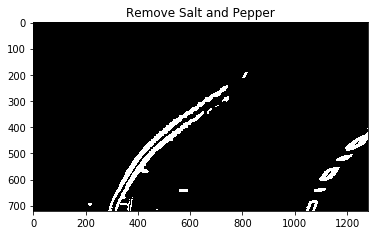

In [30]:
# Remove salt and pepper
box_kernel = (5,5)
box = cv2.boxFilter(sobel_bin, -1, box_kernel, normalize=True)
box_bin = np.ones_like(graddir)
box_bin[box < .5] = 0

plt.figure()
plt.imshow(box_bin, cmap='gray')
plt.title("Remove Salt and Pepper")

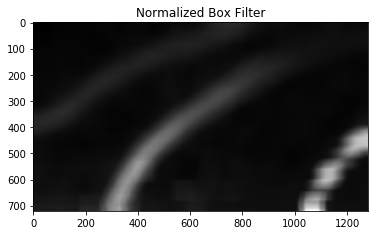

In [31]:
box = np.float32(cv2.blur(gradmag, ksize=(81,81)))
cv2.normalize(box, box, 0, 255, cv2.NORM_MINMAX)

plt.figure()
plt.imshow(box, cmap='gray')
plt.title("Normalized Box Filter")